# Read Data Sample

In [1]:
import pandas as pd
import numpy as np
import os
import time
from collections import namedtuple
pd.set_option("display.max_rows",35)
%matplotlib inline

In [2]:
class dataset:
    kdd_train_2labels = pd.read_pickle("dataset/kdd_train_2labels.pkl")
    kdd_test_2labels = pd.read_pickle("dataset/kdd_test_2labels.pkl")
    kdd_test__2labels = pd.read_pickle("dataset/kdd_test__2labels.pkl")
    
    kdd_train_5labels = pd.read_pickle("dataset/kdd_train_5labels.pkl")
    kdd_test_5labels = pd.read_pickle("dataset/kdd_test_5labels.pkl")
    

In [3]:
dataset.kdd_train_2labels.shape

(125973, 124)

In [4]:
dataset.kdd_test_2labels.shape

(22544, 124)

In [5]:
from sklearn import model_selection as ms
from sklearn import preprocessing as pp

class preprocess:
    
    output_columns_2labels = ['is_Normal','is_Attack']
    
    x_input = dataset.kdd_train_2labels.drop(output_columns_2labels, axis = 1)
    y_output = dataset.kdd_train_2labels.loc[:,output_columns_2labels]

    x_test_input = dataset.kdd_test_2labels.drop(output_columns_2labels, axis = 1)
    y_test = dataset.kdd_test_2labels.loc[:,output_columns_2labels]
    
    x_test__input = dataset.kdd_test__2labels.drop(output_columns_2labels, axis = 1)
    y_test_ = dataset.kdd_test__2labels.loc[:,output_columns_2labels]

    ss = pp.StandardScaler()

    x_train = ss.fit_transform(x_input)
    x_test = ss.transform(x_test_input)
    x_test_ = ss.transform(x_test__input)

    y_train = y_output.values
    y_test = y_test.values
    y_test_ = y_test_.values

    
preprocess.x_train.std()

0.99589320646770185

In [6]:
import tensorflow as tf
from tensorflow.contrib.legacy_seq2seq.python.ops.seq2seq import basic_rnn_seq2seq
from tensorflow.contrib.rnn import RNNCell, GRUCell, MultiRNNCell


In [7]:
class network(object):
    
    input_dim = 122
    classes = 2
    hidden_encoder_dim = 122
    hidden_layers = 1
    latent_dim = 10

    hidden_decoder_dim = 122
    lam = 0.01
    
    def __init__(self, classes, hidden_layers, num_of_features):
        self.classes = classes
        self.hidden_layers = hidden_layers
        self.latent_dim = num_of_features
            
    def build_layers(self):
        tf.reset_default_graph()
        #learning_rate = tf.Variable(initial_value=0.001)

        input_dim = self.input_dim
        classes = self.classes
        hidden_encoder_dim = self.hidden_encoder_dim
        hidden_layers = self.hidden_layers
        latent_dim = self.latent_dim
        hidden_decoder_dim = self.hidden_decoder_dim
        lam = self.lam
        
        with tf.variable_scope("Input"):
            self.x_input = tf.placeholder("float", shape=[None, 1, input_dim])
            self.y_input_ = tf.placeholder("float", shape=[None, 1, classes])
            self.keep_prob = tf.placeholder("float")
            self.lr = tf.placeholder("float")
            self.x_list = tf.unstack(self.x_input, axis= 1)
            self.y_list_ = tf.unstack(self.y_input_, axis = 1)
            self.y_ = self.y_list_[0]
            
            #GO = tf.fill((tf.shape(self.x)[0], 1), 0.5)
            
            #y_with_GO = tf.stack([self.y_, GO])
            
        with tf.variable_scope("lstm"):
            multi_cell = MultiRNNCell([GRUCell(input_dim) for i in range(hidden_layers)] )
            
            self.y, states = basic_rnn_seq2seq(self.x_list, self.y_list_, multi_cell)
            #self.y = tf.slice(self.y, [0, 0], [-1,2])
            
            #self.out = tf.squeeze(self.y)
            
            #self.y = tf.layers.dense(self.y[0], classes, activation = None)
            
            self.y = tf.slice(self.y[0], [0, 0], [-1,2])
            
        with tf.variable_scope("Loss"):
            
            self.regularized_loss = tf.losses.mean_squared_error(self.y_, self.y)
            correct_prediction = tf.equal(tf.argmax(self.y_, 1), tf.argmax(self.y, 1))
            self.tf_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = "Accuracy")

        with tf.variable_scope("Optimizer"):
            learning_rate=self.lr
            optimizer = tf.train.AdamOptimizer(learning_rate)
            gradients, variables = zip(*optimizer.compute_gradients(self.regularized_loss))
            gradients = [
                None if gradient is None else tf.clip_by_value(gradient, -1, 1)
                for gradient in gradients]
            self.train_op = optimizer.apply_gradients(zip(gradients, variables))
            #self.train_op = optimizer.minimize(self.regularized_loss)
            
        # add op for merging summary
        #self.summary_op = tf.summary.merge_all()
        self.pred = tf.argmax(self.y, axis = 1)
        self.actual = tf.argmax(self.y_, axis = 1)

        # add Saver ops
        self.saver = tf.train.Saver()
        

batch_iterations = 200

x_train, x_valid, y_train, y_valid, = ms.train_test_split(preprocess.x_train, 
                                                                          preprocess.y_train, 
                                                                          test_size=0.1)
batch_indices = np.array_split(np.arange(x_train.shape[0]), 
                                           batch_iterations)
                                                                          
for i in batch_indices:
    print(x_train[i,np.newaxis,:])
    print(y_train[i,np.newaxis,:])

In [8]:
import collections

class Train:    
    
    result = namedtuple("score", ['epoch', 'no_of_features','hidden_layers','train_score', 'test_score', 'test_score_20', 'time_taken'])

    predictions = {}

    results = []
    best_acc = 0
    best_acc_global = 0

    def train(epochs, net, h,f, lrs):
        batch_iterations = 200
        train_loss = None
        Train.best_acc = 0
        os.makedirs("dataset/tf_GRU_nsl_kdd-orig/hidden layers_{}_features count_{}".format(h,f),
                    exist_ok = True)
        with tf.Session() as sess:
            #summary_writer_train = tf.summary.FileWriter('./logs/kdd/VAE/training', graph=sess.graph)
            #summary_writer_valid = tf.summary.FileWriter('./logs/kdd/VAE/validation')

            sess.run(tf.global_variables_initializer())
            start_time = time.perf_counter()
            
            accuracy, pred_value, actual_value, y_pred = sess.run([net.tf_accuracy, 
                                                                   net.pred, 
                                                                   net.actual, net.y], 
                                                                  feed_dict={net.x_input: preprocess.x_test[:,np.newaxis,:], 
                                                                             net.y_input_: preprocess.y_test[:,np.newaxis,:], 
                                                                             net.keep_prob:1})
            
            print("Initial Accuracy, before training: {}".format(accuracy))
            
            for c, lr in enumerate(lrs):
                for epoch in range(1, (epochs+1)):
                    x_train, x_valid, y_train, y_valid, = ms.train_test_split(preprocess.x_train, 
                                                                              preprocess.y_train, 
                                                                              test_size=0.1)
                    batch_indices = np.array_split(np.arange(x_train.shape[0]), 
                                               batch_iterations)

                    for i in batch_indices:

                        _, train_loss = sess.run([net.train_op, net.regularized_loss], #net.summary_op
                                                              feed_dict={net.x_input: x_train[i,np.newaxis,:], 
                                                                         net.y_input_: y_train[i,np.newaxis,:], 
                                                                         net.keep_prob:1, net.lr:lr})
                        #summary_writer_train.add_summary(summary_str, epoch)
                        if(train_loss > 1e9):
                            print("Step {} | Training Loss: {:.6f}".format(epoch, train_loss))


                    valid_accuracy,valid_loss = sess.run([net.tf_accuracy, net.regularized_loss], #net.summary_op 
                                                          feed_dict={net.x_input: x_valid[:,np.newaxis,:], 
                                                                     net.y_input_: y_valid[:,np.newaxis,:], 
                                                                     net.keep_prob:1, net.lr:lr})
                    #summary_writer_valid.add_summary(summary_str, epoch)



                    accuracy, pred_value, actual_value, y_pred = sess.run([net.tf_accuracy, 
                                                                   net.pred, 
                                                                   net.actual, net.y], 
                                                                  feed_dict={net.x_input: preprocess.x_test[:,np.newaxis,:], 
                                                                             net.y_input_: preprocess.y_test[:,np.newaxis,:], 
                                                                             net.keep_prob:1, net.lr:lr})
                    
                    accuracy_, pred_value_, actual_value_, y_pred_ = sess.run([net.tf_accuracy, 
                                                                   net.pred, 
                                                                   net.actual, net.y], 
                                                                  feed_dict={net.x_input: preprocess.x_test_[:,np.newaxis,:], 
                                                                             net.y_input_: preprocess.y_test_[:,np.newaxis,:], 
                                                                             net.keep_prob:1, net.lr:lr})

                    print("Step {} | Training Loss: {:.6f} | Train Accuracy: {:.6f} | Test Accuracy: {:.6f}, {:.6f}".format(epoch, train_loss, valid_accuracy, accuracy, accuracy_))

                    if accuracy > Train.best_acc_global:
                                Train.best_acc_global = accuracy
                                Train.pred_value = pred_value
                                Train.actual_value = actual_value
                                Train.pred_value_ = pred_value_
                                Train.actual_value_ = actual_value_
                                Train.best_parameters = "Hidden Layers:{}, Features Count:{}".format(h, f)

                    if accuracy > Train.best_acc:

                        #net.saver.save(sess, "dataset/tf_vae_only_nsl_kdd_hidden layers_{}_features count_{}".format(epochs,h,f))
                        #Train.results.append(Train.result(epochs, f, h,valid_accuracy, accuracy))
                        #curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1]})
                        #Train.predictions.update({"{}_{}_{}".format(epochs,f,h):curr_pred})

                        Train.best_acc = accuracy
                        if not (np.isnan(train_loss)):
                            net.saver.save(sess, 
                                       "dataset/tf_GRU_nsl_kdd-orig/hidden layers_{}_features count_{}/model"
                                       .format(h,f), 
                                       global_step = epoch, 
                                       write_meta_graph=False)

                        curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1], "Prediction":pred_value})
                        Train.predictions.update({"{}_{}_{}".format((epochs+1)* (c+1),f,h):
                                                  (curr_pred, 
                                                   Train.result((epochs+1)*(c+1), f, h,valid_accuracy, accuracy, accuracy_, time.perf_counter() - start_time))})



            

In [9]:
import itertools
class Hyperparameters:
#    features_arr = [2, 4, 8, 16, 32, 64, 128, 256]
#    hidden_layers_arr = [2, 4, 6, 10]

    def start_training():

        global df_results
        global past_scores
        
        Train.predictions = {}
        Train.results = []
        
        features_arr = [1] #[4, 8, 16, 32]
        hidden_layers_arr = [1, 3, 5]

        epochs = [5]
        lrs = [1e-2, 1e-2/2, 1e-2/4]

        for e, h, f in itertools.product(epochs, hidden_layers_arr, features_arr):
            print("Current Layer Attributes - epochs:{} hidden layers:{} features count:{}".format(e,h,f))
            n = network(2,h,f)
            n.build_layers()
            Train.train(e, n, h,f, lrs)
            
        dict1 = {}
        dict2 = []
        for k, (v1, v2) in Train.predictions.items():
            dict1.update({k: v1})
            dict2.append(v2)
            
        Train.predictions = dict1
        Train.results = dict2
        df_results = pd.DataFrame(Train.results)
        temp = df_results.set_index(['no_of_features', 'hidden_layers'])

        if not os.path.isfile('dataset/tf_GRU_nsl_kdd-orig_all.pkl'):
            past_scores = temp
        else:
            past_scores = pd.read_pickle("dataset/tf_GRU_nsl_kdd-orig_all.pkl")

        past_scores.append(temp).to_pickle("dataset/tf_GRU_nsl_kdd-orig_all.pkl")



In [10]:
%%timeit -r 10

Hyperparameters.start_training()

Current Layer Attributes - epochs:5 hidden layers:1 features count:1
Initial Accuracy, before training: 0.7715134620666504
Step 1 | Training Loss: 0.002247 | Train Accuracy: 0.997857 | Test Accuracy: 0.800124, 0.619747
Step 2 | Training Loss: 0.001798 | Train Accuracy: 0.999524 | Test Accuracy: 0.878815, 0.769451
Step 3 | Training Loss: 0.000320 | Train Accuracy: 0.999921 | Test Accuracy: 0.913591, 0.835612
Step 4 | Training Loss: 0.000357 | Train Accuracy: 1.000000 | Test Accuracy: 0.932798, 0.872152
Step 5 | Training Loss: 0.000136 | Train Accuracy: 1.000000 | Test Accuracy: 0.937278, 0.880675
Step 1 | Training Loss: 0.000078 | Train Accuracy: 1.000000 | Test Accuracy: 0.955465, 0.915274
Step 2 | Training Loss: 0.000383 | Train Accuracy: 1.000000 | Test Accuracy: 0.957417, 0.918987
Step 3 | Training Loss: 0.000069 | Train Accuracy: 1.000000 | Test Accuracy: 0.957505, 0.919156
Step 4 | Training Loss: 0.000093 | Train Accuracy: 1.000000 | Test Accuracy: 0.957727, 0.919578
Step 5 | Trai

Step 4 | Training Loss: 0.005629 | Train Accuracy: 0.994205 | Test Accuracy: 0.910220, 0.829198
Step 5 | Training Loss: 0.000003 | Train Accuracy: 0.999682 | Test Accuracy: 0.973962, 0.950464
Step 1 | Training Loss: 0.000012 | Train Accuracy: 0.999682 | Test Accuracy: 0.984120, 0.969789
Step 2 | Training Loss: 0.000000 | Train Accuracy: 0.999841 | Test Accuracy: 0.974273, 0.951055
Step 3 | Training Loss: 0.000001 | Train Accuracy: 0.999762 | Test Accuracy: 0.975515, 0.953502
Step 4 | Training Loss: 0.000001 | Train Accuracy: 0.999762 | Test Accuracy: 0.974450, 0.951392
Step 5 | Training Loss: 0.000011 | Train Accuracy: 0.999682 | Test Accuracy: 0.974583, 0.951646
Step 1 | Training Loss: 0.001774 | Train Accuracy: 0.999603 | Test Accuracy: 0.984652, 0.970802
Step 2 | Training Loss: 0.000001 | Train Accuracy: 1.000000 | Test Accuracy: 0.984741, 0.971055
Step 3 | Training Loss: 0.000012 | Train Accuracy: 1.000000 | Test Accuracy: 0.985096, 0.971730
Step 4 | Training Loss: 0.000061 | Train

Step 3 | Training Loss: 0.000894 | Train Accuracy: 0.999762 | Test Accuracy: 0.982612, 0.966920
Step 4 | Training Loss: 0.000007 | Train Accuracy: 1.000000 | Test Accuracy: 0.982745, 0.967173
Step 5 | Training Loss: 0.000000 | Train Accuracy: 0.999921 | Test Accuracy: 0.982745, 0.967173
Step 1 | Training Loss: 0.000000 | Train Accuracy: 0.999921 | Test Accuracy: 0.982745, 0.967173
Step 2 | Training Loss: 0.000000 | Train Accuracy: 1.000000 | Test Accuracy: 0.982745, 0.967173
Step 3 | Training Loss: 0.000000 | Train Accuracy: 1.000000 | Test Accuracy: 0.982745, 0.967173
Step 4 | Training Loss: 0.000003 | Train Accuracy: 1.000000 | Test Accuracy: 0.982745, 0.967173
Step 5 | Training Loss: 0.000000 | Train Accuracy: 1.000000 | Test Accuracy: 0.982745, 0.967173
Current Layer Attributes - epochs:5 hidden layers:5 features count:1
Initial Accuracy, before training: 0.7603353261947632
Step 1 | Training Loss: 0.004781 | Train Accuracy: 0.998492 | Test Accuracy: 0.973208, 0.949367
Step 2 | Trai

Step 2 | Training Loss: 0.000039 | Train Accuracy: 1.000000 | Test Accuracy: 0.940605, 0.887004
Step 3 | Training Loss: 0.000053 | Train Accuracy: 1.000000 | Test Accuracy: 0.940605, 0.887004
Step 4 | Training Loss: 0.000035 | Train Accuracy: 1.000000 | Test Accuracy: 0.940960, 0.887679
Step 5 | Training Loss: 0.000049 | Train Accuracy: 1.000000 | Test Accuracy: 0.941670, 0.889030
Current Layer Attributes - epochs:5 hidden layers:3 features count:1
Initial Accuracy, before training: 0.5593506097793579
Step 1 | Training Loss: 0.000022 | Train Accuracy: 0.999603 | Test Accuracy: 0.997560, 0.995359
Step 2 | Training Loss: 0.000004 | Train Accuracy: 0.999603 | Test Accuracy: 0.996584, 0.993502
Step 3 | Training Loss: 0.001769 | Train Accuracy: 0.999762 | Test Accuracy: 0.997826, 0.995865
Step 4 | Training Loss: 0.000001 | Train Accuracy: 0.999762 | Test Accuracy: 0.997826, 0.995865
Step 5 | Training Loss: 0.000000 | Train Accuracy: 1.000000 | Test Accuracy: 0.997782, 0.995781
Step 1 | Trai

Initial Accuracy, before training: 0.6875443458557129
Step 1 | Training Loss: 0.002989 | Train Accuracy: 0.999286 | Test Accuracy: 0.836764, 0.689451
Step 2 | Training Loss: 0.000408 | Train Accuracy: 1.000000 | Test Accuracy: 0.917938, 0.843882
Step 3 | Training Loss: 0.000255 | Train Accuracy: 1.000000 | Test Accuracy: 0.929870, 0.866582
Step 4 | Training Loss: 0.001016 | Train Accuracy: 1.000000 | Test Accuracy: 0.931112, 0.868945
Step 5 | Training Loss: 0.000094 | Train Accuracy: 1.000000 | Test Accuracy: 0.956175, 0.916624
Step 1 | Training Loss: 0.000048 | Train Accuracy: 1.000000 | Test Accuracy: 0.938831, 0.883629
Step 2 | Training Loss: 0.000095 | Train Accuracy: 0.999921 | Test Accuracy: 0.939762, 0.885401
Step 3 | Training Loss: 0.000069 | Train Accuracy: 1.000000 | Test Accuracy: 0.939629, 0.885148
Step 4 | Training Loss: 0.000024 | Train Accuracy: 0.999841 | Test Accuracy: 0.940428, 0.886667
Step 5 | Training Loss: 0.000047 | Train Accuracy: 0.999921 | Test Accuracy: 0.940

Step 5 | Training Loss: 0.005704 | Train Accuracy: 0.993332 | Test Accuracy: 0.786684, 0.594262
Step 1 | Training Loss: 0.004059 | Train Accuracy: 0.994840 | Test Accuracy: 0.796576, 0.613165
Step 2 | Training Loss: 0.007358 | Train Accuracy: 0.994761 | Test Accuracy: 0.787216, 0.595443
Step 3 | Training Loss: 0.005621 | Train Accuracy: 0.994920 | Test Accuracy: 0.833925, 0.684473
Step 4 | Training Loss: 0.006635 | Train Accuracy: 0.995555 | Test Accuracy: 0.784865, 0.590886
Step 5 | Training Loss: 0.005466 | Train Accuracy: 0.994761 | Test Accuracy: 0.777457, 0.577384
Step 1 | Training Loss: 0.003807 | Train Accuracy: 0.996031 | Test Accuracy: 0.786773, 0.594684
Step 2 | Training Loss: 0.001771 | Train Accuracy: 0.996825 | Test Accuracy: 0.788946, 0.598565
Step 3 | Training Loss: 0.002613 | Train Accuracy: 0.997301 | Test Accuracy: 0.810060, 0.639072
Step 4 | Training Loss: 0.001716 | Train Accuracy: 0.996746 | Test Accuracy: 0.847188, 0.709451
Step 5 | Training Loss: 0.001673 | Train

Step 4 | Training Loss: 0.000000 | Train Accuracy: 1.000000 | Test Accuracy: 0.999468, 0.998987
Step 5 | Training Loss: 0.000000 | Train Accuracy: 1.000000 | Test Accuracy: 0.999468, 0.998987
Step 1 | Training Loss: 0.000000 | Train Accuracy: 1.000000 | Test Accuracy: 0.999512, 0.999072
Step 2 | Training Loss: 0.000000 | Train Accuracy: 1.000000 | Test Accuracy: 0.999512, 0.999072
Step 3 | Training Loss: 0.000000 | Train Accuracy: 1.000000 | Test Accuracy: 0.999512, 0.999072
Step 4 | Training Loss: 0.000001 | Train Accuracy: 1.000000 | Test Accuracy: 0.999512, 0.999072
Step 5 | Training Loss: 0.000000 | Train Accuracy: 1.000000 | Test Accuracy: 0.999512, 0.999072
Current Layer Attributes - epochs:5 hidden layers:5 features count:1
Initial Accuracy, before training: 0.7087029814720154
Step 1 | Training Loss: 0.029560 | Train Accuracy: 0.982537 | Test Accuracy: 0.783801, 0.589789
Step 2 | Training Loss: 0.000902 | Train Accuracy: 0.998968 | Test Accuracy: 0.979817, 0.962869
Step 3 | Trai

In [11]:
g = df_results.groupby(by=['no_of_features'])
idx = g['test_score'].transform(max) == df_results['test_score']
df_results[idx].sort_values(by = 'test_score', ascending = False)

,epoch,no_of_features,hidden_layers,train_score,test_score,test_score_20,time_taken
3,18,1,3,1.0,0.999512,0.999072,117.723715


In [12]:
df_results.sort_values(by = 'test_score', ascending = False)

,epoch,no_of_features,hidden_layers,train_score,test_score,test_score_20,time_taken
3,18,1,3,1.000000,0.999512,0.999072,117.723715
2,6,1,3,1.000000,0.999468,0.998987,54.473063
4,6,1,5,0.999047,0.994455,0.990717,52.805204
1,12,1,1,0.999841,0.933907,0.874262,38.998433
0,6,1,1,1.000000,0.928007,0.863038,19.724738


In [13]:
pd.Panel(Train.predictions).to_pickle("dataset/tf_GRU_nsl_kdd_predictions.pkl")
df_results.to_pickle("dataset/tf_GRU_nsl_kdd_scores.pkl")

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j].round(4),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(actual_value, pred_value):
    from sklearn.metrics import confusion_matrix
    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, preprocess.output_columns_2labels, normalize = False,
                         title = Train.best_parameters)

Confusion matrix, without normalization
[[ 9710     1]
 [    0 12833]]


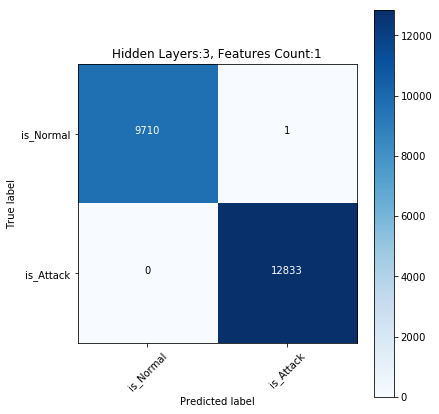

In [15]:
plot(actual_value = Train.actual_value, pred_value = Train.pred_value)

Confusion matrix, without normalization
[[2151    1]
 [   0 9698]]


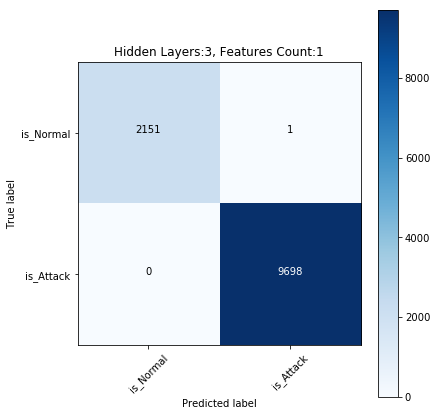

In [16]:
plot(actual_value = Train.actual_value_, pred_value = Train.pred_value_)

In [17]:
#4.5 GB
pd.Series(Train.pred_value).to_csv('GRU_prediction_values.csv')

In [18]:
past_scores

epoch  train_score  test_score  test_score_20  \
no_of_features hidden_layers                                                  
1              1                  6     1.000000    0.937278       0.880675   
               1                 12     1.000000    0.957727       0.919578   
               1                 18     1.000000    0.958215       0.920506   
               3                  6     1.000000    0.999867       0.999747   
               3                 12     1.000000    0.999911       0.999831   
               5                  6     0.997460    0.894029       0.798397   
               5                 12     0.999762    0.962473       0.928608   
               5                 18     0.999921    0.972498       0.947679   
               1                  6     1.000000    0.937278       0.880675   
               1                 12     1.000000    0.957727       0.919578   
               1                 18     1.000000    0.958215       0.920506   
               3                  6     1.000000    0.999867       0.999747   
               3                 12     1.000000    0.999911       0.999831   
               5                  6     0.997460    0.894029       0.798397   
               5                 12     0.999762    0.962473       0.928608   
               5                 18     0.999921    0.972498       0.947679   
               1                  6     0.999841    0.937278       0.880675   
...                             ...          ...         ...            ...   
               1                  6     1.000000    0.956175       0.916624   
               3                  6     1.000000    0.999468       0.998987   
               5                  6     0.979759    0.807399       0.635105   
               5                 12     0.997936    0.907825       0.826160   
               5                 18     0.999762    0.965401       0.934262   
               1                  6     0.999921    0.947303       0.899747   
               1                 18     1.000000    0.950231       0.905316   
               3                  6     0.999603    0.986027       0.973418   
               3                 12     1.000000    0.997782       0.995781   
               5                  6     0.993332    0.786684       0.594262   
               5                 12     0.994920    0.833925       0.684473   
               5                 18     0.998571    0.921265       0.850464   
               1                  6     0.999206    0.958259       0.920591   
               3                  6     1.000000    0.999290       0.998650   
               5                  6     0.974361    0.780829       0.584895   
               5                 12     0.995634    0.797241       0.614346   
               5                 18     0.999762    0.966288       0.935865   

                              time_taken  
no_of_features hidden_layers              
1              1               14.150092  
               1               25.316301  
               1               42.115427  
               3               39.416124  
               3               47.097980  
               5               62.728601  
               5              124.716464  
               5              186.515223  
               1               14.150092  
               1               25.316301  
               1               42.115427  
               3               39.416124  
               3               47.097980  
               5               62.728601  
               5              124.716464  
               5              186.515223  
               1               14.001841  
...                                  ...  
               1               19.982509  
               3               33.803133  
               5               35.490781  
               5              171.106554  
               5              255.321470  
               1               

In [19]:
pgb = past_scores.groupby(by=['no_of_features', 'hidden_layers'])
pgb.mean()

epoch  train_score  test_score  \
no_of_features hidden_layers                                       
1              1              11.307692     0.999930    0.947564   
               3               9.000000     0.999815    0.998428   
               5              11.379310     0.996620    0.911742   

                              test_score_20  time_taken  
no_of_features hidden_layers                             
1              1                   0.900243   27.491425  
               3                   0.997009   48.438291  
               5                   0.832329  129.095418

In [20]:
pgb.std()

epoch  train_score  test_score  \
no_of_features hidden_layers                                      
1              1              5.182812     0.000159    0.011661   
               3              4.242641     0.000278    0.003207   
               5              4.901995     0.006017    0.081695   

                              test_score_20  time_taken  
no_of_features hidden_layers                             
1              1                   0.022184   14.036460  
               3                   0.006102   35.543510  
               5                   0.155172   67.656089